# Kernel Methods and Hyperparameter Optimization
Kernel methods are a type of machine learning that is particularly sensitive to choice of hyperparameters (variables that control how an algorithm learns).
Here, we'll show you how to adjust them with sklearn's hyperparameter optimization tools.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV, ShuffleSplit, train_test_split
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import mean_absolute_error
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from time import perf_counter
from tqdm import tqdm
import pandas as pd
import numpy as np
import os

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


## Kernel Methods
The ["kernel" trick](https://en.wikipedia.org/wiki/Kernel_method) is make a supervised learning problem easier by creating new input features based on pairwise similarities between a new input point and each point from the training set. The kernel creates a new set of $N$ features where each feature is the similarity between a certain entry and each of $N$ points from the training set. The similiarity function used to compute the new features is called _the kernel_.

We will first demonstrate how the kernel can drastically simplify the learning problem.

In [2]:
x = np.arange(-2, 2.1, 1)
y = (-1 <= x) & (x <= 1)

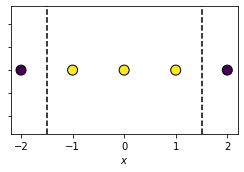

In [3]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.scatter(x, [0]*5, c=y, s=100, ec='k')
ax.set_ylim(ax.get_ylim())
for i in [-1.5, 1.5]:
    ax.plot([i]*2, ax.get_ylim(), 'k--')

ax.set_yticklabels([])
ax.set_xlabel('$x$')
fig.tight_layout()

Note how this problem is not linearly separable. You need 2 rules to separate the two classes.

Now, we apply a kernel trick to create a new set of features. We use the ["RBF Kernel"](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.rbf_kernel.html)
to generate new features. The RBF kernel uses a Gaussian function to create new features

$f_i = k(x, x_i) = \exp(-\gamma(x - x_i)^2))$

Applying the kernel function to all of the data yields the so-called, "kernel matrix" where

$K_{ij} = k(x_i, y_j)$

We will use this term in the remainder of the notebook

In [4]:
f = rbf_kernel(x[:, None])

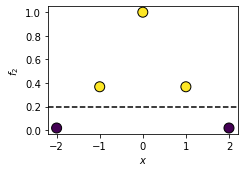

In [5]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.scatter(x, f[:, 2], c=y, s=100, ec='k')
ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xlim(), [0.2]*2, 'k--')

ax.set_ylabel('$f_2$')
ax.set_xlabel('$x$')
fig.tight_layout()

Now my points are linear separable based on one of my new features, $f_2$. We've made the learning problem easier by transforming the data to a new space.

### Theory: Kernel Ridge Regression
You can also use Kernel methods for regression. Kernel ridge regression (KRR) creates a model of the functional form:

$f(x) = \sum_i c_i K(x, x_i)$

where the sum is over all points in the training set and $x_i$ is training point $i$.

The coefficients of this equation, $\c_i$, are learned by minimizing

$\sum_i (y_i - f(x_i))^2 + \alpha \left\Vert{\bf c}\right\Vert^2$

where the squared error to the training data is $\sum_i (y_i - f(x_i))^2$,
the sum of squares of the weights is $\left\Vert{\bf c}\right\Vert^2$ (i.e., $L_2$-norm), 
and $\lambda$ controls the tradeoff between minimizing model error and
model complexity (larger weights lead to a more complex model).

This equation has a convenient [analytic solution](https://en.wikipedia.org/wiki/Tikhonov_regularization)
based on the fact it involves solving a system of linear equations.
The costly step in that equation is a matrix inversion, which can be solved efficiently 
using [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition) - a 
convenience due to symmetry properties of the kernel function.

### Building a KRR Model using `scikit-learn`
We will use the [`KernelRidge`](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html) method built into sklearn to explain how to use KRR. 

We will choose the "RBF" kernel introduced above for our example as it is particularly good at fitting non-linear functions and, conveniently, also very sensitive to hyperparmaeter choice.

In [6]:
krr = KernelRidge(kernel='rbf')

In [7]:
krr.get_params()

{'alpha': 1,
 'coef0': 1,
 'degree': 3,
 'gamma': None,
 'kernel': 'rbf',
 'kernel_params': None}

The two parameters we are interested in fitting are:
1. `gamma`: Controls the width of the kernel functions (see $\gamma$ in the equation above)
1. `alpha`:  As in our formula above, controls complexity

Make some initial data

In [8]:
n_points = 8
X = np.random.uniform(0, 10, (n_points, 1))  # 2D array with one column
y = -0.6 * X * (X - 11) + np.random.normal(size=(n_points, 1))

To illustrate the importance of hyperparameters, let's show how the model predictions change as a function of the kernel width (see `\gamma` above)

Text(0, 0.5, '$y$')

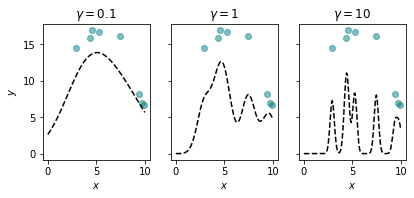

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(6.5, 2.5), sharey=True)

x_plot = np.linspace(0, 10, 128)[:, None]
for ax, g in zip(axs, [0.1, 1, 10]):
    # Adjust parameter, fit and run model
    krr.set_params(gamma=g)
    krr.fit(X, y)
    y_plot = krr.predict(x_plot)
    
    ax.scatter(X, y, color='teal', alpha=0.5)
    ax.plot(x_plot, y_plot, 'k--')

    ax.set_title(f'$\gamma = {g}$')
    ax.set_xlabel('$x$')
axs[0].set_ylabel('$y$')

Note how larger values of gamma give "sharper" models. We can see a different effect with changing the `alpha`

Text(0, 0.5, '$y$')

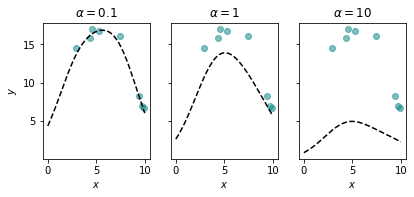

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(6.5, 2.5), sharey=True)

krr.set_params(gamma=0.1)
for ax, a in zip(axs, [0.1, 1, 10]):
    # Adjust parameter, fit and run model
    krr.set_params(alpha=a)
    krr.fit(X, y)
    y_plot = krr.predict(x_plot)
    
    ax.scatter(X, y, color='teal', alpha=0.5)
    ax.plot(x_plot, y_plot, 'k--')

    ax.set_title(f'$\\alpha = {a}$')
    ax.set_xlabel('$x$')
axs[0].set_ylabel('$y$')

`alpha` instead controls fitness with the training set. 

Our challenge with using KRR is to find the right mix of parameters for each problem.

### Fitting Hyperparameters
Scikit-learn provides a convenient tool, [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), for optimizing hyperparameters that we will use for this exercise.

It works by wrapping your model inside of class that tests many variations of your model to using a series of parameters you define. 

You must provide `GridSearchCV` with:
1. A basic model with all the settings you do not want to change
1. A grid of parameters you with to try out (all will be evaluated)
1. A scheme to define how to score the model

In [11]:
gs = GridSearchCV(
    estimator=krr, # Set the estimator to be KRR
    param_grid={'alpha': np.logspace(-8, 0, 32)},  # The range
    cv=ShuffleSplit(test_size=0.25, random_state=1),  # Use 10, 75/25% splits
    scoring='neg_mean_absolute_error',  # Score based on MAE
)

It works just like an other machine learning model in scikit-learn

In [12]:
%%time
gs.fit(X, y)

CPU times: user 1.12 s, sys: 9.06 ms, total: 1.13 s
Wall time: 1.12 s


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=1, test_size=0.25, train_size=None),
             estimator=KernelRidge(alpha=10, gamma=0.1, kernel='rbf'),
             param_grid={'alpha': array([1.00000000e-08, 1.81160919e-08, 3.28192787e-08, 5.94557071e-08,
       1.07710506e-07, 1.95129342e-07, 3.53498111e-07, 6.40400427e-07,
       1.16015530e-06, 2.10174801e-06, 3.80754602e-06, 6.89778538e-06,
       1.24960914e-05, 2.26380341e-05, 4.10112707e-05, 7.42963951e-05,
       1.34596032e-04, 2.43835410e-04, 4.41734470e-04, 8.00250228e-04,
       1.44974067e-03, 2.62636353e-03, 4.75794431e-03, 8.61953566e-03,
       1.56152301e-02, 2.82886943e-02, 5.12480588e-02, 9.28414545e-02,
       1.68192432e-01, 3.04698957e-01, 5.51995432e-01, 1.00000000e+00])},
             scoring='neg_mean_absolute_error')

Except that one of its outputs contains the scores over the many models we tried

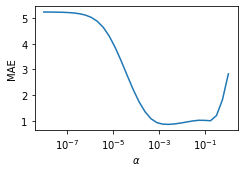

In [13]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.semilogx(np.array(gs.cv_results_['param_alpha']), -1*gs.cv_results_['mean_test_score'])

ax.set_xlabel('$\\alpha$')
ax.set_ylabel('MAE')
fig.tight_layout()

We can also find the best parameter is about $10^-3$

In [14]:
gs.best_params_

{'alpha': 0.00262636352765333}

Note how the error can change by about a factor of 8 when we adjust $\alpha$!

**Your Turn** Fit the model changing alpha using the ranges we used in the last example but with only 16 steps and using a logarithmic space between $10^{-4}$ and $10^1$ in 16 steps

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=1, test_size=0.25, train_size=None),
             estimator=KernelRidge(alpha=10, gamma=0.1, kernel='rbf'),
             param_grid={'alpha': array([1.00000000e-08, 3.41454887e-08, 1.16591440e-07, 3.98107171e-07,
       1.35935639e-06, 4.64158883e-06, 1.58489319e-05, 5.41169527e-05,
       1.84784980e-04, 6.30957344e-04, 2.15443469e-03, 7.35642254e-03,
       2.51188643e-02, 8.57695899e-02, 2.92864456e-01, 1.00000000e+00]),
                         'gamma': array([1.00000000e-04, 2.15443469e-04, 4.64158883e-04, 1.00000000e-03,
       2.15443469e-03, 4.64158883e-03, 1.00000000e-02, 2.15443469e-02,
       4.64158883e-02, 1.00000000e-01, 2.15443469e-01, 4.64158883e-01,
       1.00000000e+00, 2.15443469e+00, 4.64158883e+00, 1.00000000e+01])},
             scoring='neg_mean_absolute_error')

Double click for answer

<div style='display: None'>
gs = GridSearchCV(
    estimator=krr, # Set the estimator to be KRR
    param_grid={
        'alpha': np.logspace(-8, 0, 16),
        'gamma': np.logspace(-4, 1, 16),
    },  # The range
    cv=ShuffleSplit(test_size=0.25, random_state=1),  # Use 10, 75/25% splits
    scoring='neg_mean_absolute_error',  # Score based on MAE
)
gs.fit(X, y)
</div>

Once you have the GridSearch model fit, you can use it like any other.

Text(0, 0.5, '$y$')

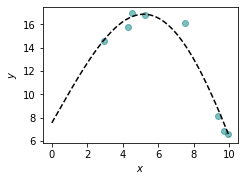

In [16]:
fig, ax = plt.subplots(figsize=(3.5, 2.5), sharey=True)
# Run model with `.predict`
y_plot = gs.predict(x_plot)

ax.scatter(X, y, color='teal', alpha=0.5)
ax.plot(x_plot, y_plot, 'k--')

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

We now fit the data really well and you now know about:
1. The basics of Kernel methods
1. How to fit hyperparameters in sklearn!